# Saving data in the background

The QCoDeS Measurement allows for the actual data saving to take place in a background thread. This notebook provides an example of using that feature to reduce the overall time spent running the measurement.

## Can I haz speedup?

If the time you spend actually writing the data to disk is comparable to the time it takes you to acquire the data (e.g. by waiting for a lock-in amplifier to integrate or an algorithm to return a result), then you can indeed expect a speedup of up to a factor of 2. If your measurement time is clearly dominated by either the acquisition or the writing to the DB file, then writing the data in the background won't offer you much of a speedup. 

## Example Measurement

We'll acquire a 2D heatmap and pretend that the acquisition is fairly slow. We'll also print how long the acquisition and the saving takes. We have chosen a *fair* example showing *some* speed-up. It is indeed possible to tailor situations where the speed-up is larger, e.g. by saving big (smth like 3 x 100_000_000 points per save) numpy arrays, but such datasets are not easily visaulised. In this notebook we get a decent speed-up and two nice heatmaps.

In [1]:
import os
import time
import tempfile

import numpy as np

from qcodes.instrument.parameter import Parameter
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_dataset
from qcodes.dataset.experiment_container import new_experiment
from qcodes.dataset.sqlite.database import initialise_or_create_database_at

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/runner/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


Qcodes Logfile : /home/runner/.qcodes/logs/210220-4870-qcodes.log


In [2]:
dbname = os.path.join(tempfile.gettempdir(), os.urandom(24).hex()) + ".db"
initialise_or_create_database_at(dbname)
new_experiment('saving_data_in_bg', 'no_sample')

0it [00:00, ?it/s]

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v1 -> v2:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v1 -> v2: 100%|██████████| 1/1 [00:00<00:00, 578.44it/s]


0it [00:00, ?it/s]

Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]

Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]

Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v4 -> v5:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v4 -> v5: 100%|██████████| 1/1 [00:00<00:00, 856.33it/s]


0it [00:00, ?it/s]

Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]

Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v6 -> v7:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v6 -> v7: 100%|██████████| 1/1 [00:00<00:00, 82.78it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v7 -> v8:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v7 -> v8: 100%|██████████| 1/1 [00:00<00:00, 1026.00it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v8 -> v9:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v8 -> v9: 100%|██████████| 1/1 [00:00<00:00, 1166.06it/s]

saving_data_in_bg#no_sample#1@/tmp/01b66572ac1ffb82b1b4a6ca4bd08b636cd39626208e6391.db
--------------------------------------------------------------------------------------

In [3]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def get_response():
    """
    Simulated slow instrument response
    """
    freqs = frequency.get()
    volt = voltage.get()
    time.sleep(0.1)
    volt += 0.2*np.random.rand()
    noise = 0.01*np.random.randn(len(freqs))
    return gaussian(freqs, volt, 2) + 0.01* noise

In [4]:
voltage = Parameter('voltage', unit='V', set_cmd=None, get_cmd=None)
frequency = Parameter('frequency', unit='Hz', set_cmd=None, get_cmd=None)
response = Parameter('response', unit='V^2/Hz', get_cmd=get_response)

meas = Measurement()
meas.register_parameter(voltage)
meas.register_parameter(frequency)
meas.register_parameter(response, setpoints=[voltage, frequency])

In [5]:
N = 10_000
M = 10

## Data saving in the main thread

This is the default QCoDeS behaviour.

In [6]:
t0 = time.perf_counter()

saving_time = 0
generation_time = 0

with meas.run() as datasaver:
    init_time = time.perf_counter() - t0

    for volt in np.sin(np.linspace(-np.pi, np.pi, M)):
        t1 = time.perf_counter()

        freqs = np.linspace(-10, 10, N)
        frequency(freqs)
        voltage(volt)

        resp = response()

        t2 = time.perf_counter()

        generation_time += t2 - t1

        datasaver.add_result((frequency, freqs),
                             (voltage, volt),
                             (response, resp))
        t3 = time.perf_counter()

        saving_time += t3 - t2
t4 = time.perf_counter()
saving_time += t4 - t3

print('Report:')
print(f'Number of data points saved: {M} x {N} points')
print(f'Init time:            {init_time} s')
print(f'Data generation time: {generation_time} s')
print(f'Data saving time:     {saving_time} s')
print(f'Total time:           {t4-t0} s')

Starting experimental run with id: 1. 


Report:
Number of data points saved: 10 x 10000 points
Init time:            0.03376171200000044 s
Data generation time: 1.0123232299999927 s
Data saving time:     1.3650794169999472 s
Total time:           2.411326062999933 s


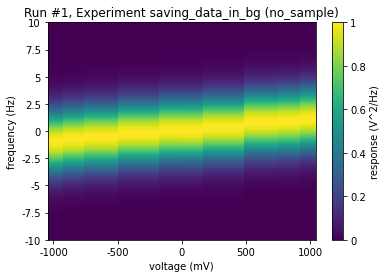

In [7]:
_ = plot_dataset(datasaver.dataset)

## Saving in a background thread

To save in a background thread, simply pass the `write_in_background` kwarg as you `run` the measurement.

In [8]:
t0 = time.perf_counter()

saving_time = 0
generation_time = 0

# ONLY DIFFERENCE IN THE NEXT LINE
with meas.run(write_in_background=True) as datasaver:  # <---- THIS LINE DIFFERENT
    # THE PREVIOUS LINE CHANGED
    
    init_time = time.perf_counter() - t0

    for volt in np.sin(np.linspace(-np.pi, np.pi, M)):
        t1 = time.perf_counter()

        freqs = np.linspace(-10, 10, N)
        frequency(freqs)
        voltage(volt)

        resp = response()

        t2 = time.perf_counter()

        generation_time += t2 - t1

        datasaver.add_result((frequency, freqs),
                             (voltage, volt),
                             (response, resp))
        t3 = time.perf_counter()

        saving_time += t3 - t2
t4 = time.perf_counter()
saving_time += t4 - t3

print('Report:')
print(f'Number of data points saved: {M} x {N} points')
print(f'Init time:            {init_time} s')
print(f'Data generation time: {generation_time} s')
print(f'Data saving time:     {saving_time} s')
print(f'Total time:           {t4-t0} s')

Starting experimental run with id: 2. 


Report:
Number of data points saved: 10 x 10000 points
Init time:            0.035085242999912225 s
Data generation time: 1.0152037700000847 s
Data saving time:     0.4770582129998502 s
Total time:           1.5275126309999223 s


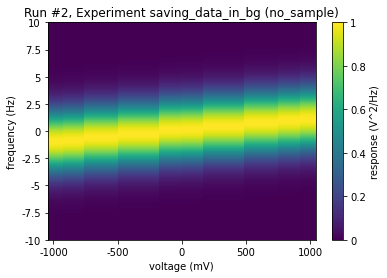

In [9]:
_ = plot_dataset(datasaver.dataset)

Note that if you perform more than one measurement concurrently, they must all either perform the saving in the main thread on in the background. Mixing between foreground and background is not allowed.

## Conclusion

For an example experiment saving 10 rows of 10,000 data points, out-of-thread data writing reduced the time spent in the main thread saving data by almost 70% and thus the overall measurement time by more than 35%.